Here you will find:
- A plot of the kind of EEG raw time-courses we are working on;
- Representations of the inferred parameters of the Hidden Markov Model
- A representation of the Time-delay embedding (TDE) of an EEG time-course, which can be an input for the HMM 
- A representation of the principal components we get after applying a PCA on our TDE (which can also be an input for the HMM)
- The inferred HMM states' probability time-course on one trial plotted with the wavelet transform of the trial to see what the HMM spots
- Some methods to understand the structure of xarray Datasets and DataArrays
- Contrasts between the inferred states' fractional occupancies following different conditions

In [1]:
import numpy as np
from loader import load_oneIC
import h5py
import xarray as xr

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from wavelet_transform import wavelet_transform2

In [4]:
import mne

In [5]:
directory = "/home/INT/malfait.n/Documents/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

path = f"{directory}/{file}"

mat_file = h5py.File(path, "r")
cells_refs = mat_file['FCK_LOCKED_IC_JYOTIKA']

n_IC = 4
n_subj = 23

In [6]:
subj = 2
IC = 3
n_states = 3
figures_dir = "tde-hmm2/Multivariate/Run on all subj then refined subj by subj - 10 lags and no PCA/figures/"
data_dir = "tde-hmm2/Multivariate/Run on all subj then refined subj by subj - 10 lags and no PCA/data/"

In [7]:
figures_dir2 = "tde-hmm2/Univariate/Run subj by subj - 58 lags and 40 PC/figures/"
data_dir2 = "tde-hmm2/Univariate/Run subj by subj - 58 lags and 40 PC/data/"

### Raw time-course

In [8]:
data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)

Loading the raw timecourse


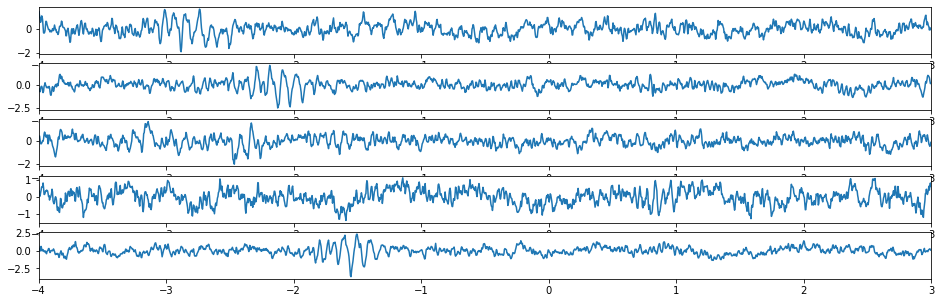

In [9]:
time = data["time_axis"]
timecourse = data["raw_timecourse_256Hz"]

n = 5

plt.figure(figsize=(16, n))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(time, timecourse[i])
    plt.xlim([-4, 3])

### Model parameters

Starting probability of the HMM states: 

 [1.87514215e-277 3.79511282e-001 6.20488718e-001] 


Transition matrix of the HMM states: 

 [[0.96163622 0.01777919 0.02058459]
 [0.0130378  0.95103453 0.03592767]
 [0.01207311 0.03809897 0.94982792]] 




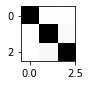

Mean-array for each state:


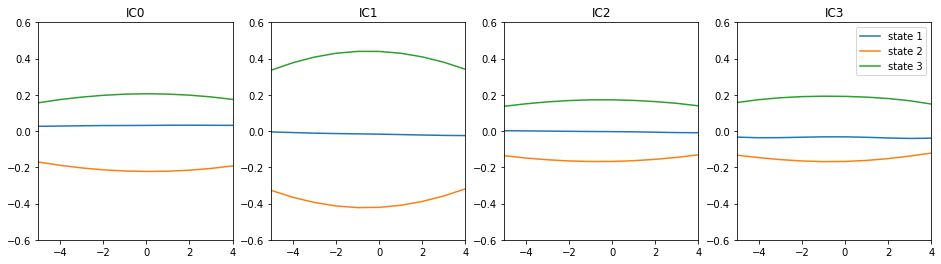

Covariance matrix for each state:


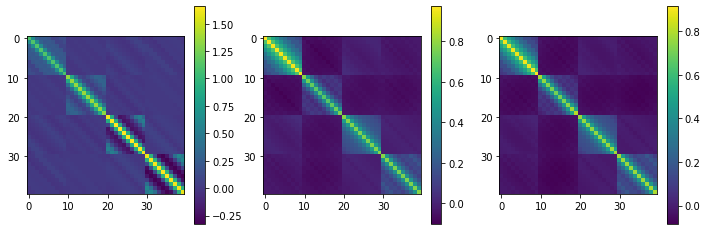

In [10]:
file = open(data_dir + f"suAll_lg10co0st{n_states}1GaussianHMM_woPCA_preModel.pkl", "rb")
model = pickle.load(file)

print("Starting probability of the HMM states: \n\n", model.startprob_, "\n\n")

print("Transition matrix of the HMM states: \n\n", model.transmat_, "\n\n")
plt.figure(figsize=(1,1))
plt.imshow(model.transmat_, cmap='gray_r')
plt.show()

print("Mean-array for each state:")
plt.figure(figsize=(4*n_IC, 4))
for state in range(n_states):
    for IC in range(n_IC):
        plt.subplot(1, n_IC, IC+1)
        plt.plot(np.arange(-5, 5), model.means_[state, IC*10:IC*10+10])
        plt.title(f"IC{IC}")
        plt.xlim([-5,4])
        plt.ylim([-0.6,0.6])
plt.legend([f'state {i+1}' for i in range(3)], loc='upper right')
plt.show()

print("Covariance matrix for each state:")
plt.figure(figsize=(4*n_states, 4))
for state in range(n_states):
    plt.subplot(1, n_states, state+1)
    plt.imshow(model.covars_[state])
    plt.colorbar()
plt.show()

Starting probability of the HMM states: 

 [0.00000000e+00 1.00000000e+00 5.19055632e-36] 


Transition matrix of the HMM states: 

 [[0.96332421 0.02272704 0.01394875]
 [0.00972497 0.96933688 0.02093815]
 [0.00437489 0.0110928  0.9845323 ]]


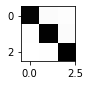

Mean-array for each state:


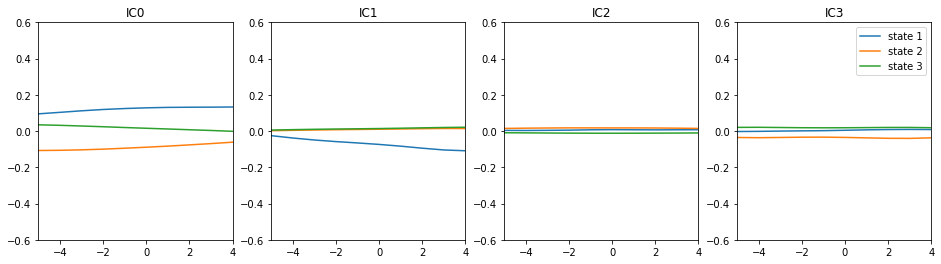

Covariance matrix for each state:


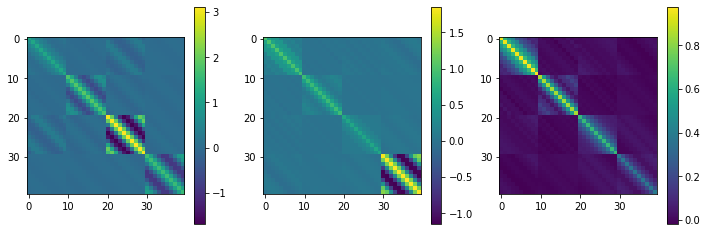

In [11]:
file = open(data_dir + f"su2All_lg10co0st{n_states}1GaussianHMM_model.pkl", "rb")
model = pickle.load(file)

print("Starting probability of the HMM states: \n\n", model.startprob_, "\n\n")

print("Transition matrix of the HMM states: \n\n", model.transmat_)
plt.figure(figsize=(1,1))
plt.imshow(model.transmat_, cmap='gray_r')
plt.show()

print("Mean-array for each state:")
plt.figure(figsize=(4*n_IC, 4))
for state in range(n_states):
    for IC in range(n_IC):
        plt.subplot(1, n_IC, IC+1)
        plt.plot(np.arange(-5, 5), model.means_[state, IC*10:IC*10+10])
        plt.title(f"IC{IC}")
        plt.xlim([-5,4])
        plt.ylim([-0.6,0.6])
plt.legend([f'state {i+1}' for i in range(3)], loc='upper right')
plt.show()

print("Covariance matrix for each state:")
plt.figure(figsize=(4*n_states, 4))
for state in range(n_states):
    plt.subplot(1, n_states, state+1)
    plt.imshow(model.covars_[state])
    plt.colorbar()
plt.show()

### Time-delay embedding

In [12]:
def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid

Loading the raw timecourse


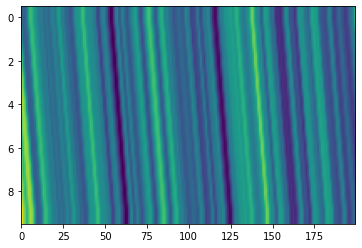

In [13]:
data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
lags = np.arange(-5, 5)

xe, valid = embedx(data['raw_timecourse_256Hz'][0].reshape(-1, 1), lags)
plt.figure()
plt.imshow(xe[0,:200,:].T, aspect='auto')

### Principal component analysis on the Time-delay embedding

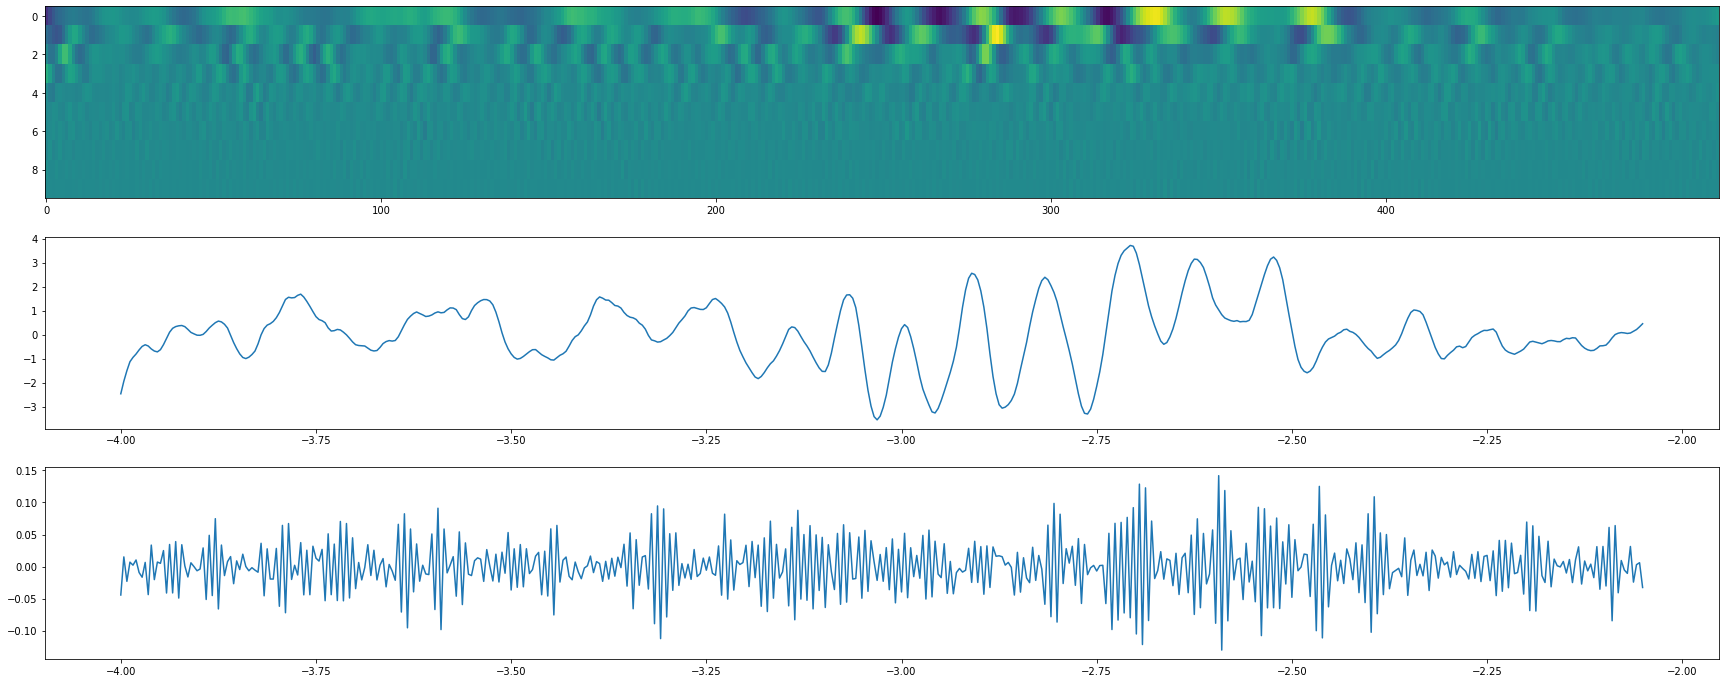

In [14]:
pca = PCA(n_components=10)
y = pca.fit_transform(xe[0, :, :])

plt.figure(figsize=(30,12))
plt.subplot(311)
plt.imshow(y[:500,:].T, aspect='auto')
plt.subplot(312)
plt.plot(data["time_axis"][:500], y[:500, 0])
plt.subplot(313)
plt.plot(data["time_axis"][:500], y[:500, 9])

### HMM over tfr

Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse
Loading the raw timecourse


Text(0.5, 0, 'Frequency (Hz)')

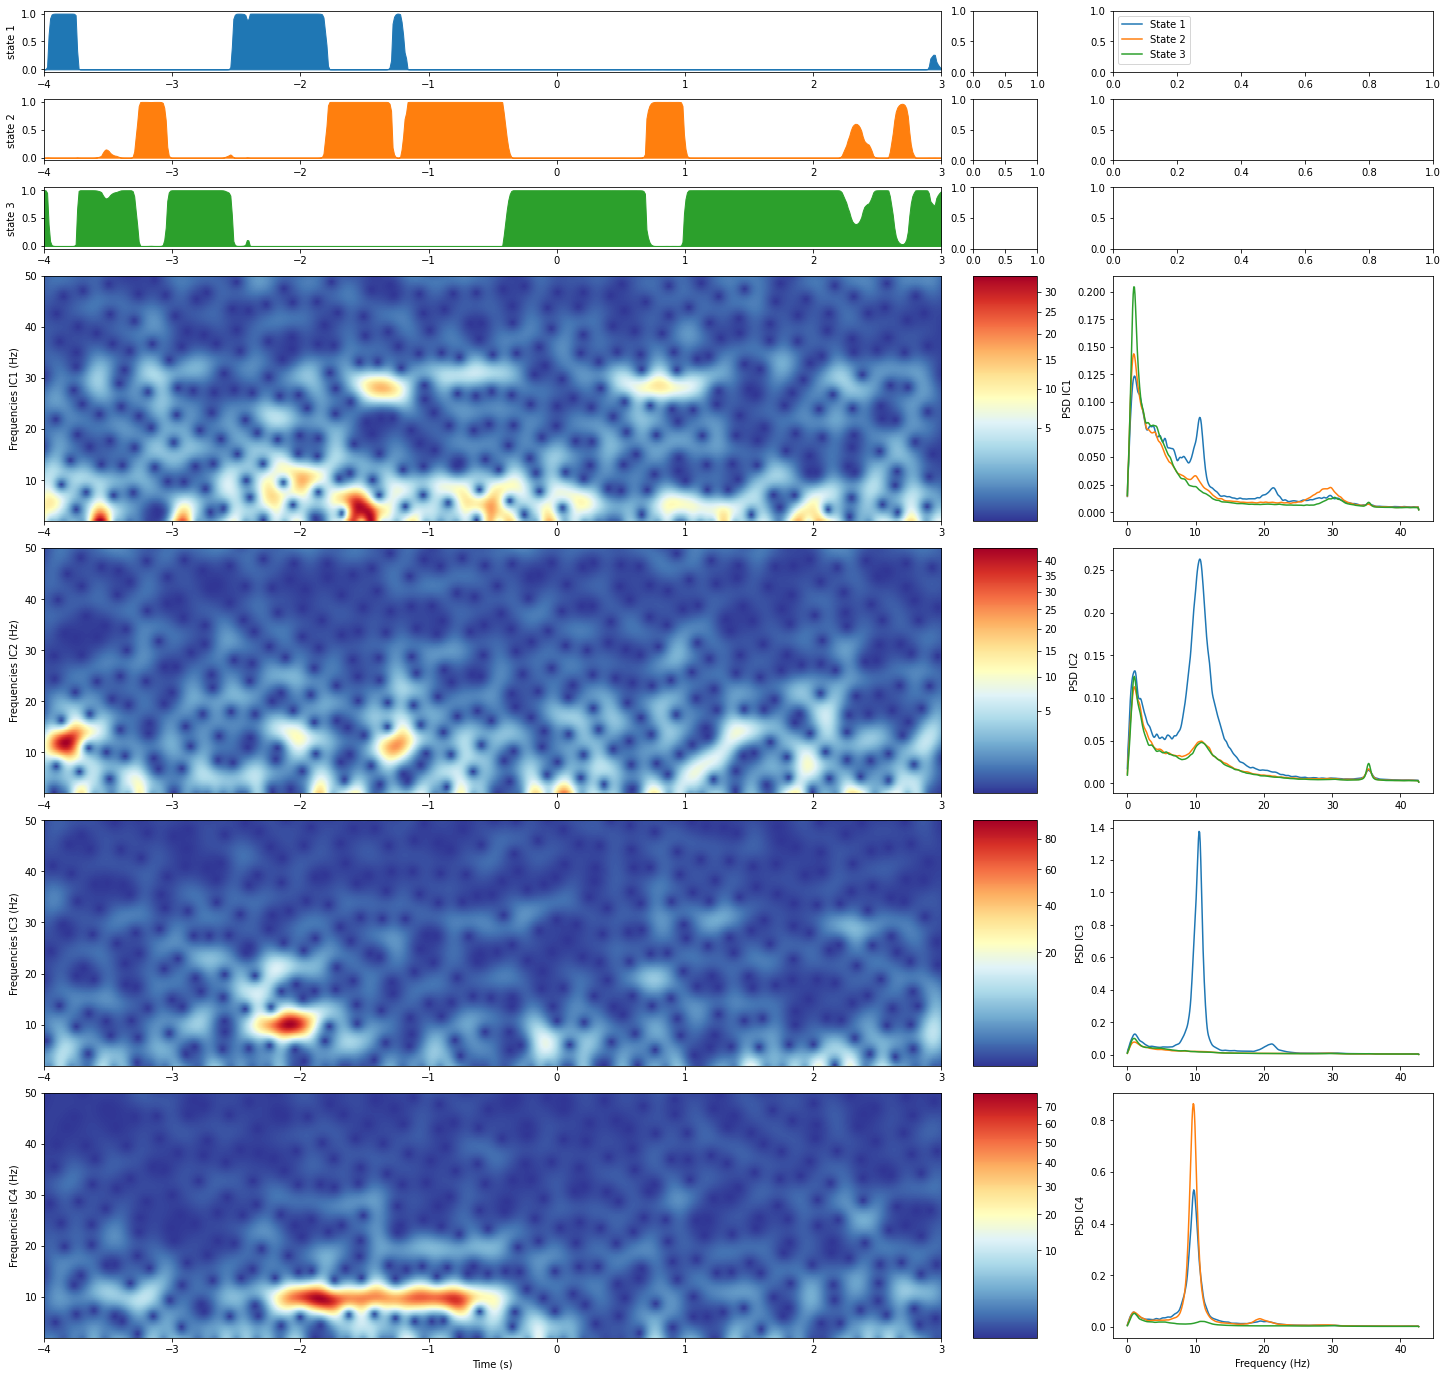

In [15]:
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])

widths = [14, 1, 5]
heights = [1 for i in range(n_states)] + [4,4,4,4]
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, nrows=(n_states+4), constrained_layout=True,
                         gridspec_kw=gs_kw)
ds = xr.open_dataset(data_dir + f"su{subj}-{n_states}states_woPCA_data_Multi.nc")
for state in ds["states"].values:
    ax = f_axes[state-1,0]
    ax.fill_between(ds["time"].values, ds["states_timecourse"].values[1, :, state-1], color=f"C{state-1}")
    ax.set_xlim([-4, 3])
    ax.set_ylabel(f"state {state}")
for IC in ds["IC"].values:
#     try:
        ax = f_axes[IC+n_states-1,0]
        data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
        tfr = wavelet_transform2(data, info, trial=2)
        mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                               norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
        ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
        fig.colorbar(mappable, cax=f_axes[IC+n_states-1,1])
#     except:
#         pass
for i in range(len(ds["IC"].values)):
    IC = ds["IC"].values[i]
    ax = f_axes[IC+n_states-1,2]
    ax.plot(ds["freq"].values, ds["states_psd"].values[i,].T)
    ax.set_ylabel(f'PSD IC{IC}')
ax = f_axes[n_states,2]
lines = ax.get_lines()
labels = [f"State {i}" for i in range (1, n_states+1)]
ax = f_axes[0,2]
ax.legend(lines, labels, loc='upper left')
ax = f_axes[n_states+3,0]
ax.set_xlabel(f'Time (s)') 
ax = f_axes[n_states+3,2]
ax.set_xlabel(f'Frequency (Hz)')   

Loading the raw timecourse


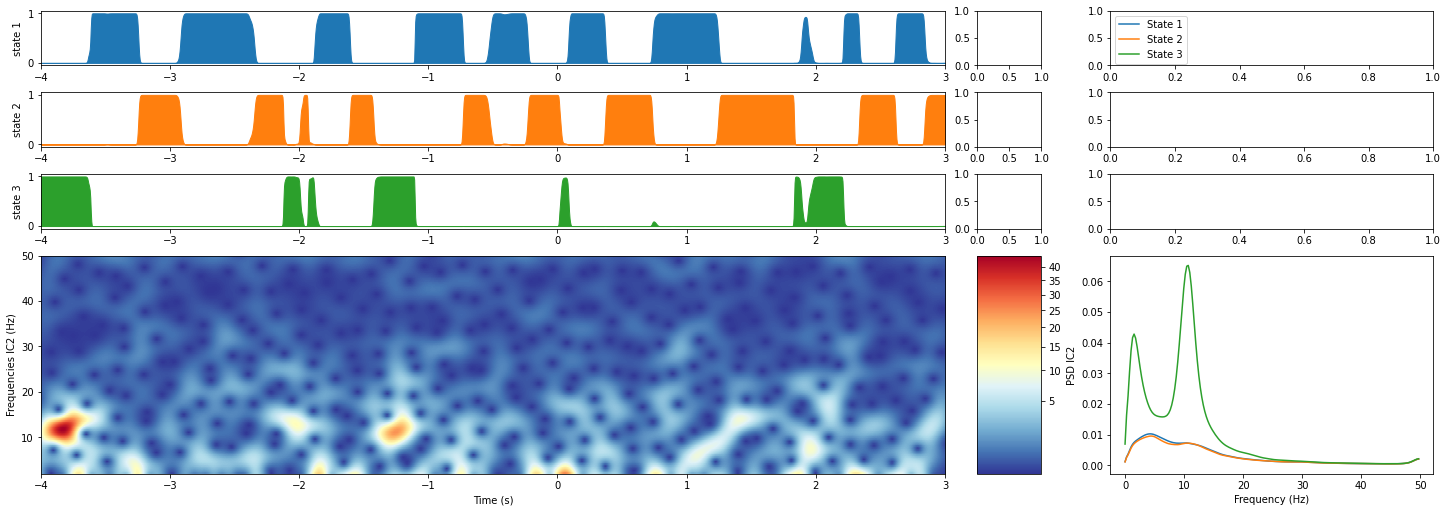

In [16]:
info = mne.create_info(ch_names=['signal'], sfreq=256, ch_types=['eeg'])
IC = 2
widths = [14, 1, 5]
heights = [1 for i in range(n_states)] + [4]
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
ds = xr.open_dataset(data_dir2 + f"su{subj}-{n_states}states_data_v2.nc")
start_t = ds["time"].values[0]
end_t = ds["time"].values[-1]
idx = np.searchsorted(ds["IC"].values, IC)
fig, f_axes = plt.subplots(figsize=(sum(widths),sum(heights)), ncols=3, 
                            nrows=(n_states+1), constrained_layout=True,
                            gridspec_kw=gs_kw)
for state in ds["states"].values:
    ax = f_axes[state-1,0]
    ax.fill_between(ds["time"].values, ds["states_timecourse"].values[1, idx, :, state-1], color=f"C{state-1}")
    ax.set_xlim([-4, 3])
    ax.set_ylabel(f"state {state}")

ax = f_axes[n_states,0]
data, n_trials = load_oneIC(mat_file, cells_refs, subj, IC, comp=False)
tfr = wavelet_transform2(data, info, trial=2)
mappable = ax.imshow(tfr[0], aspect='auto', origin='lower', extent=[-4, 3, 2, 50], 
                       norm=colors.PowerNorm(gamma=0.5), cmap='RdYlBu_r')
ax.set_ylabel(f'Frequencies IC{IC} (Hz)')
ax.set_xlabel(f'Time (s)')
fig.colorbar(mappable, cax=f_axes[n_states,1])

ax = f_axes[n_states,2]
ax.plot(ds["freq"].values, ds["states_psd"].values[idx,].T)
ax.set_ylabel(f'PSD IC{IC}')
ax.set_xlabel(f'Frequency (Hz)') 
lines = ax.get_lines()
labels = [f"State {i}" for i in range (1, n_states+1)]
ax = f_axes[0,2]
ax.legend(lines, labels, loc='upper left')

IC = 3

### xarray Datasets and DataArrays

In [17]:
ds = xr.open_dataset(data_dir + f"su2-{n_states}states_woPCA_data_Multi.nc")
print(ds.keys, "\n\n")
ds

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
  * IC                 (IC) int32 1 2 3 4
  * states             (states) int32 1 2 3
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 ...
    frac_occ           (time, states) float64 ...
    states_psd         (IC, states, freq) float64 ...> 




<xarray.Dataset>
Dimensions:            (IC: 4, freq: 501, states: 3, time: 598, trials: 675)
Coordinates:
  * time               (time) float64 -4.0 -3.988 -3.977 ... 2.973 2.984 2.996
  * freq               (freq) float64 0.0 0.08533 0.1707 ... 42.5 42.58 42.67
  * IC                 (IC) int32 1 2 3 4
  * states             (states) int32 1 2 3
Dimensions without coordinates: trials
Data variables:
    states_timecourse  (trials, time, states) float64 ...
    frac_occ           (time, states) float64 ...
    states_psd         (IC, states, freq) float64 ...

In [18]:
ds["time"]

<xarray.DataArray 'time' (time: 598)>
array([-4.      , -3.988281, -3.976562, ...,  2.972656,  2.984375,  2.996094])
Coordinates:
  * time     (time) float64 -4.0 -3.988 -3.977 -3.965 ... 2.973 2.984 2.996

In [19]:
ds["frac_occ"]

<xarray.DataArray 'frac_occ' (time: 598, states: 3)>
array([[0.147345, 0.247283, 0.60389 ],
       [0.148504, 0.249598, 0.600416],
       [0.148878, 0.242521, 0.60712 ],
       ...,
       [0.13125 , 0.238392, 0.628876],
       [0.134659, 0.242555, 0.621304],
       [0.144022, 0.244043, 0.610454]])
Coordinates:
  * time     (time) float64 -4.0 -3.988 -3.977 -3.965 ... 2.973 2.984 2.996
  * states   (states) int32 1 2 3

In [20]:
ds["frac_occ"]["time"]

<xarray.DataArray 'time' (time: 598)>
array([-4.      , -3.988281, -3.976562, ...,  2.972656,  2.984375,  2.996094])
Coordinates:
  * time     (time) float64 -4.0 -3.988 -3.977 -3.965 ... 2.973 2.984 2.996

In [21]:
ds["frac_occ"].values

array([[0.14734534, 0.24728317, 0.60389001],
       [0.14850391, 0.24959832, 0.60041629],
       [0.14887762, 0.24252051, 0.60712038],
       ...,
       [0.13124965, 0.23839243, 0.62887644],
       [0.13465933, 0.24255525, 0.62130393],
       [0.14402165, 0.24404304, 0.61045383]])

### Contrasts on Fractional occupancy

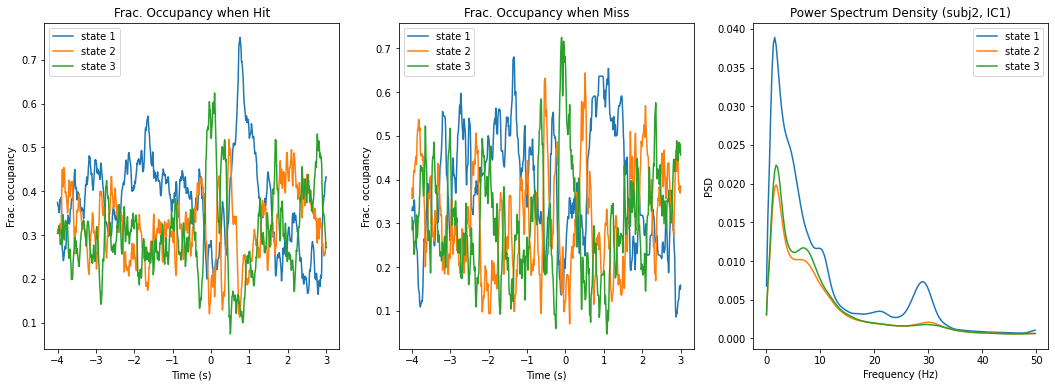

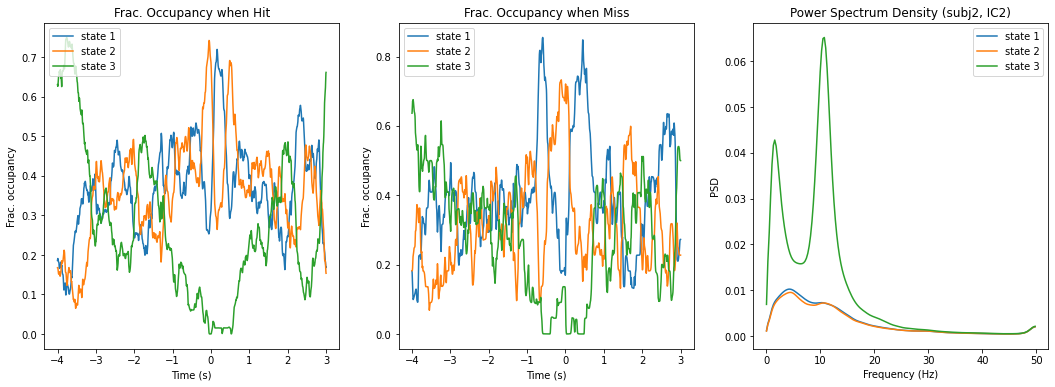

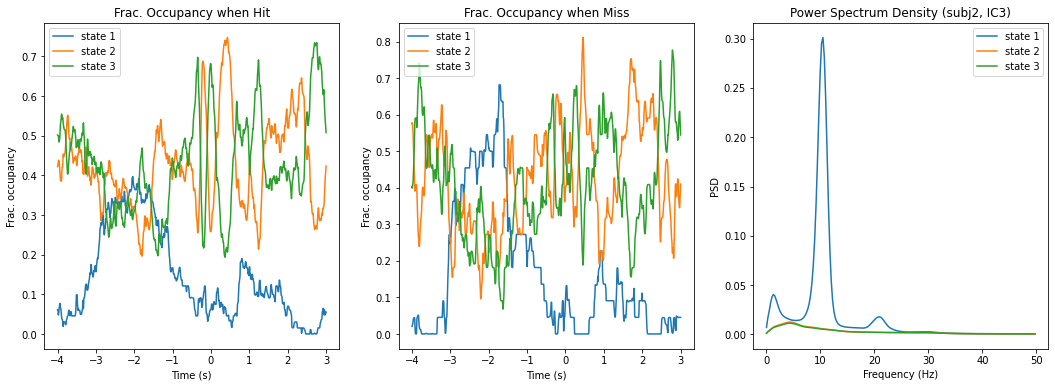

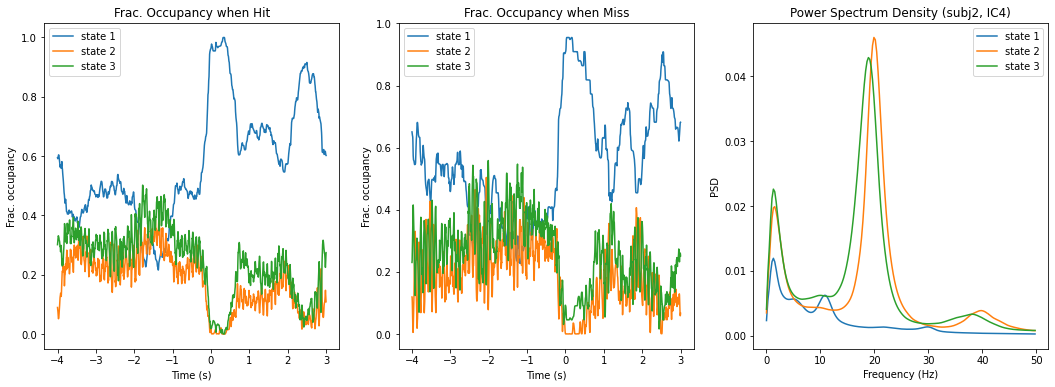

In [22]:
ds = xr.open_dataset(data_dir2 + f"su{subj}-{n_states}states_data_v2.nc")
cell = mat_file[cells_refs[ds["IC"].values[0]-1,subj-1]]
trialinfo = cell['trialinfo'][0, :].astype(int)
hit = ((trialinfo/10000).astype(int)==1)
miss = ((trialinfo/10000).astype(int)==2)

vect = (trialinfo/1000).astype(int)-((trialinfo/10000).astype(int))*10

frac_occ_hit = (ds["states_timecourse"][:, hit&(vect==5)].sum("trials")/(hit&(vect==5)).sum())
frac_occ_miss = (ds["states_timecourse"][:, miss&(vect==5)].sum("trials")/(miss&(vect==5)).sum())
for i in range(len(ds["IC"].values)):
    labels = [f"state {state}" for state in ds["states"].values]
    fig = plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title(f'Frac. Occupancy when Hit')
    plt.plot(ds["time"], frac_occ_hit.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(132)
    plt.title(f'Frac. Occupancy when Miss')
    plt.plot(ds["time"], frac_occ_miss.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(133)
    plt.title(f"Power Spectrum Density (subj{subj}, IC{ds['IC'].values[i]})")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')

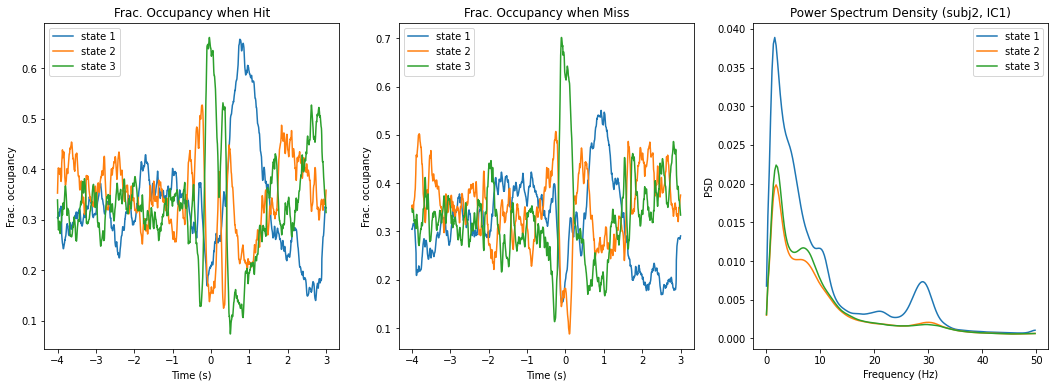

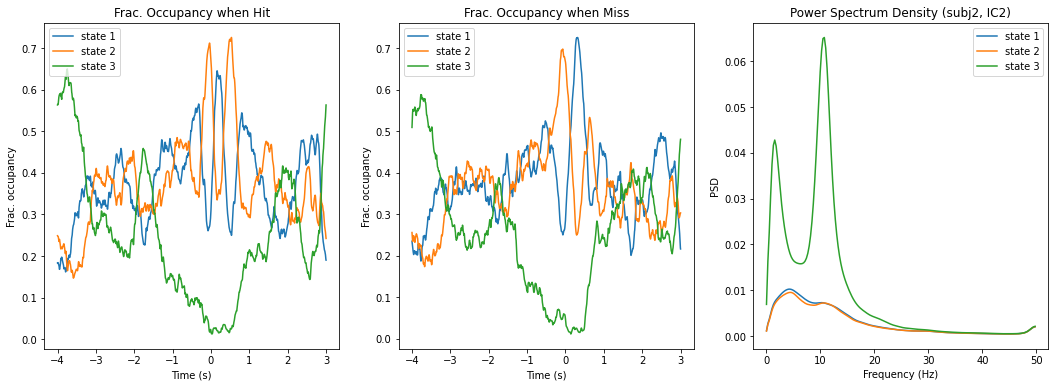

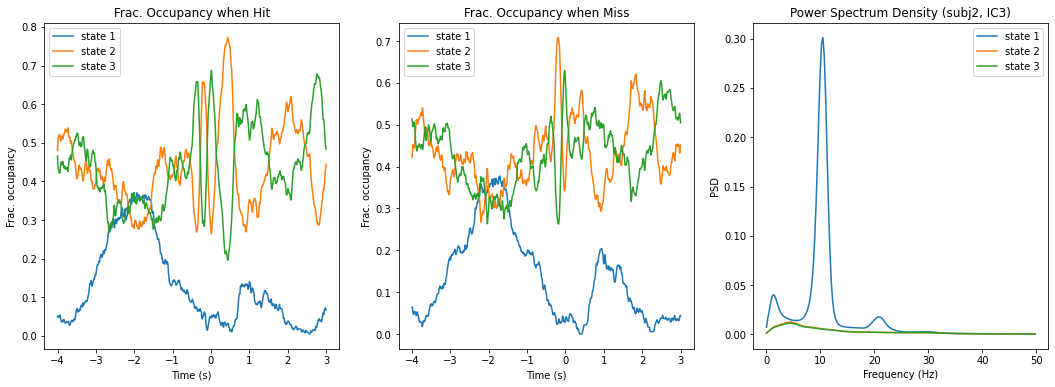

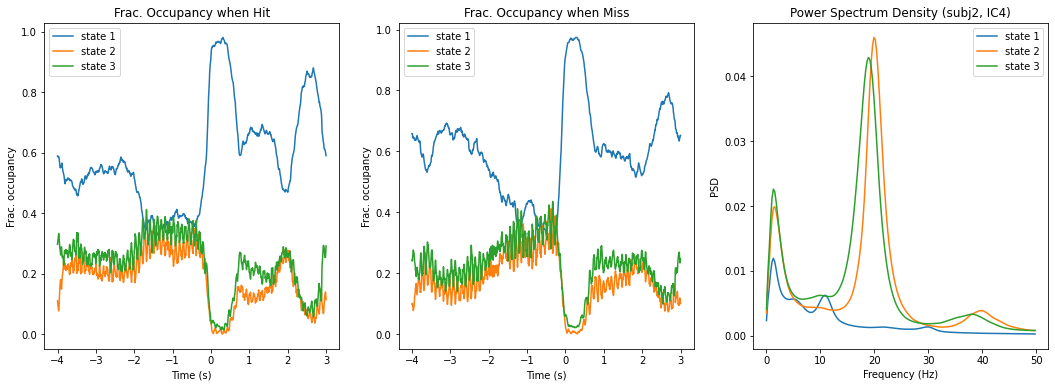

In [23]:
vect = trialinfo-((trialinfo/10).astype(int))*10
vect = ((vect==0)|(vect==1))

frac_occ_hit = (ds["states_timecourse"][:, hit&vect].sum("trials")/(hit&vect).sum())
frac_occ_miss = (ds["states_timecourse"][:, miss&vect].sum("trials")/(miss&vect).sum())
for i in range(len(ds["IC"].values)):
    labels = [f"state {state}" for state in ds["states"].values]
    fig = plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title(f'Frac. Occupancy when Hit')
    plt.plot(ds["time"], frac_occ_hit.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(132)
    plt.title(f'Frac. Occupancy when Miss')
    plt.plot(ds["time"], frac_occ_miss.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(133)
    plt.title(f"Power Spectrum Density (subj{subj}, IC{ds['IC'].values[i]})")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')

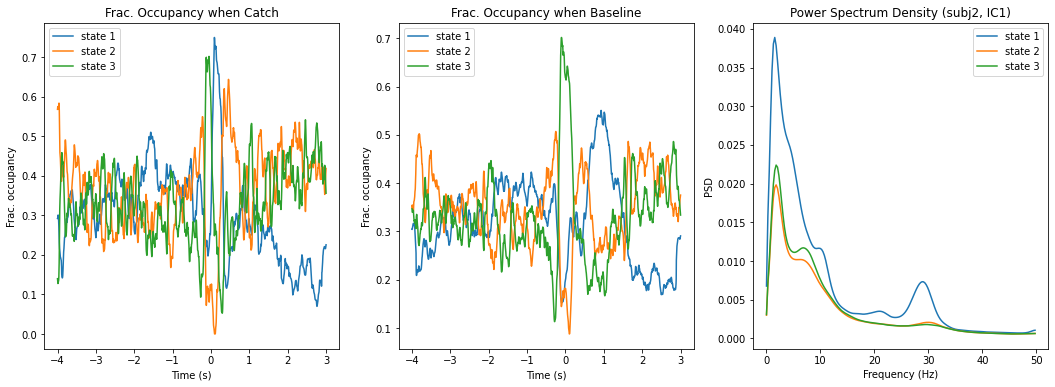

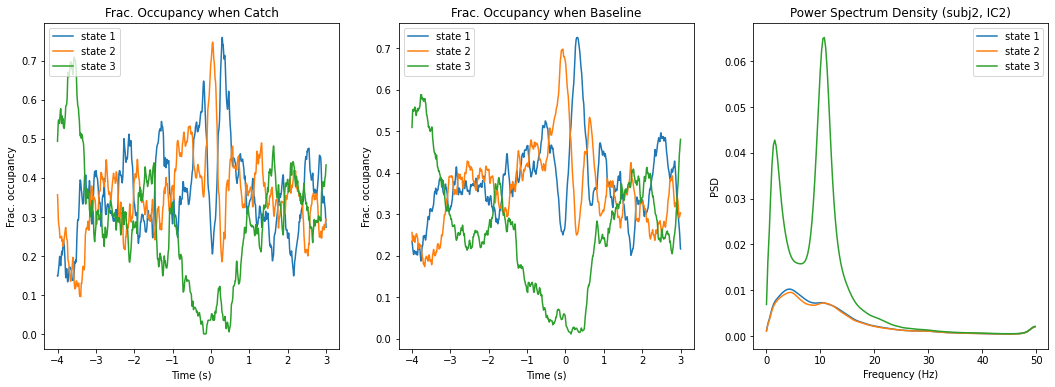

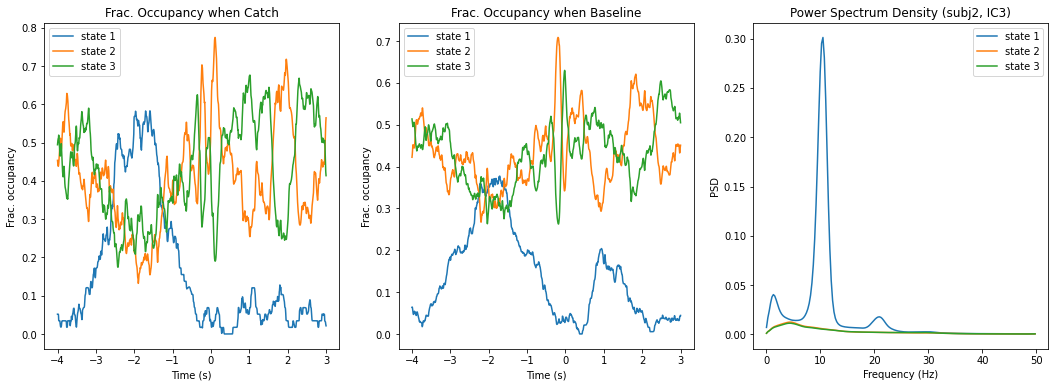

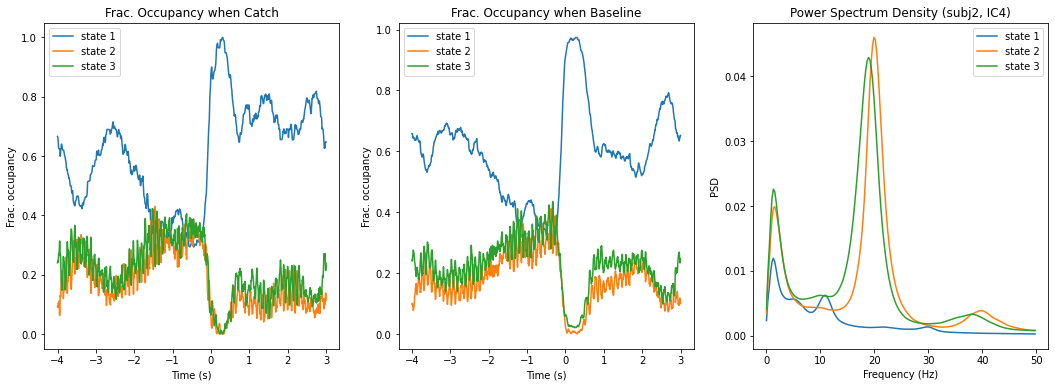

In [24]:
catchVSbaseline = trialinfo-((trialinfo/10).astype(int))*10
catch = (catchVSbaseline==2)
baseline = ( (catchVSbaseline==0)|(catchVSbaseline==1) )

vect = (trialinfo/10000).astype(int)
vect = (vect==2)

frac_occ_hit = (ds["states_timecourse"][:, catch&vect].sum("trials")/(catch&vect).sum())
frac_occ_miss = (ds["states_timecourse"][:, baseline&vect].sum("trials")/(baseline&vect).sum())
for i in range(len(ds["IC"].values)):
    labels = [f"state {state}" for state in ds["states"].values]
    fig = plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.title(f'Frac. Occupancy when Catch')
    plt.plot(ds["time"], frac_occ_hit.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(132)
    plt.title(f'Frac. Occupancy when Baseline')
    plt.plot(ds["time"], frac_occ_miss.values[i,])
    plt.xlabel('Time (s)')
    plt.ylabel('Frac. occupancy')
    plt.legend(labels, loc='upper left')
    plt.subplot(133)
    plt.title(f"Power Spectrum Density (subj{subj}, IC{ds['IC'].values[i]})")
    plt.plot(ds["freq"], ds["states_psd"].values[i,].T)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.legend(labels, loc='upper right')